In [0]:
# Importing packages
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField, StringType, IntegerType 
from pyspark.sql.types import ArrayType, DoubleType, BooleanType
from pyspark.sql.functions import col,array_contains, lit, min, max, mean, year, desc
from pyspark.sql.functions import *	
from pyspark.sql.types import *
import pyspark.sql.functions as F
# from pyspark_dist_explore import hist
import matplotlib.pyplot as plt
from itertools import product
from pyspark.sql.window import Window
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
# ML tools
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
import numpy as np
import seaborn as sns
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from sklearn.metrics import confusion_matrix
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [0]:
resp = spark.read.options(header='True', delimiter=',', inferSchema = True).csv("/FileStore/tables/Retail_Data_Response.csv")

annual_features = spark.read.options(header='True', delimiter=',', inferSchema = True).csv("/FileStore/tables/annual_features_2.csv")

mth_rolling_features = spark.read.options(header='True', delimiter=',', inferSchema = True).csv("/FileStore/tables/mth_rolling_features_3.csv").fillna(0)

annual_day_of = spark.read.options(header='True', delimiter=',', inferSchema = True).csv("/FileStore/tables/annual_day_of_week_counts.csv")

mth_day_counts = spark.read.options(header='True', delimiter=',', inferSchema = True).csv("/FileStore/tables/mth_day_counts.csv").fillna(0)

days_since_last = spark.read.options(header='True', delimiter=',', inferSchema = True).csv("/FileStore/tables/days_since_last_txn.csv").fillna(0)

In [0]:
annual_features_outputs = annual_features.join\
(annual_day_of,on='customer_id', how="left_outer")\
.join(resp, on='customer_id', how="left_outer")\
.drop("customer_id")

In [0]:
resp = resp.withColumn("CLNT_NO", resp["customer_id"])
monthly_features_outputs = mth_rolling_features.join(mth_day_counts, on=['CLNT_NO', 'ME_DT'],how='left_outer').join(days_since_last, on=['CLNT_NO', 'ME_DT'],how='left_outer').join(resp, on = 'CLNT_NO',how='left_outer').drop("CLNT_NO", "ME_DT", "customer_id")

In [0]:
annual_out = annual_features_outputs.fillna(0)
month_out = monthly_features_outputs.fillna(0)

In [0]:
def getRatio(df:DataFrame):
    positive = df.filter("response=1.0")
    sampleratio = positive.count()/df.count()
    return sampleratio

In [0]:
ratio_annual = getRatio(annual_out)
positive_weight = 1 - ratio_annual
negative_weight = ratio_annual

In [0]:
ratio_month = getRatio(month_out)
positive_weight_month = 1 - ratio_month
negative_weight_month = ratio_month

In [0]:
annual_out = annual_out.withColumn("weight", when(annual_out.response == 1.0, positive_weight).otherwise(negative_weight))

In [0]:
month_out = month_out.withColumn("weight", when(month_out.response == 1.0, positive_weight_month).otherwise(negative_weight_month))

In [0]:
ann_stages = []
mon_stages = []
ann_input_col = annual_out.columns
ann_input_col.remove("response")
ann_input_col.remove("weight")
vecassembler_annual = VectorAssembler(inputCols= ann_input_col, outputCol = "features")

annual_out = vecassembler_annual.transform(annual_out)
# annual_train = vecassembler_annual.transform(annual_train)
# annual_test = vecassembler_annual.transform(annual_test)

mon_input_col = month_out.columns
mon_input_col.remove("response")
mon_input_col.remove("weight")
vecassembler_month = VectorAssembler(inputCols= mon_input_col, outputCol = "features")

month_out = vecassembler_month.transform(month_out)
# month_train = vecassembler_month.transform(month_train)
# month_test = vecassembler_month.transform(month_test)

ann_sel_col = ['features'] + ['response'] + ['weight']
mon_sel_col = ['features'] + ['response'] + ['weight']
annual_out = annual_out.select(ann_sel_col)
month_out = month_out.select(mon_sel_col)
# annual_train = annual_train.select(ann_sel_col)
# annual_test = annual_test.select(ann_sel_col)
# month_train = month_train.select(mon_sel_col)
# month_test = month_test.select(mon_sel_col)

In [0]:
annual_train, annual_test = annual_out.randomSplit([0.3333, 0.6667], seed = 1148)
month_train, month_test = month_out.randomSplit([0.3333, 0.6667], seed = 1148)

In [0]:
SS = StandardScaler().setInputCol("features").setOutputCol("Features")

annual_train_s = SS.fit(annual_train)
annual_train_s = annual_train_s.transform(annual_train)
annual_test_s = SS.fit(annual_test)
annual_test_s = annual_test_s.transform(annual_test)
month_train_s = SS.fit(month_train)
month_train_s = month_train_s.transform(month_train)
month_test_s = SS.fit(month_test)
month_test_s = month_test_s.transform(month_test)

## Annual LR

In [0]:
LR = LogisticRegression(featuresCol = 'Features', labelCol = 'response', weightCol = "weight", elasticNetParam = 1.0)
paramGrid = (ParamGridBuilder()
             .addGrid(LR.regParam, [0.001, 0.01, 0.05, 0.1, 1]) \
             .addGrid(LR.maxIter, [3, 5, 10]) \
             .build())

evaluator = BinaryClassificationEvaluator(labelCol='response', weightCol= 'weight')
tvs = TrainValidationSplit(estimator=LR,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    trainRatio=0.8)

model_LR = tvs.fit(annual_train_s)
predictions_annual = model_LR.bestModel.transform(annual_test_s)
auc_test_LR = evaluator.evaluate(predictions_annual)

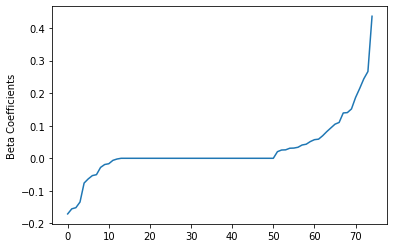

Best Param (regParam):  0.01
Best Param (MaxIter):  10


In [0]:
beta = np.sort(model_LR.bestModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()
print('Best Param (regParam): ', model_LR.bestModel._java_obj.getRegParam())
print('Best Param (MaxIter): ', model_LR.bestModel._java_obj.getMaxIter())

In [0]:
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        # Note this collect could be inefficient for large datasets 
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter, 
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


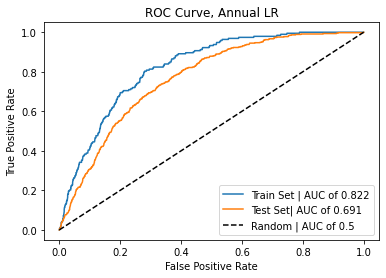

In [0]:
# Returns as a list (false positive rate, true positive rate)
preds = predictions_annual.select('response','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['response'])))
points = CurveMetrics(preds).get_curve('roc')
trainingSummary = model_LR.bestModel.summary
roc = trainingSummary.roc.toPandas()
# test set
predictionAndLabels = predictions_annual.select('response','prediction').rdd.map(lambda row: (float(row['prediction']), float(row['response'])))
metrics = BinaryClassificationMetrics(predictionAndLabels)
plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve, Annual LR')
plt.plot(roc['FPR'], roc['TPR'], label = 'Train Set | AUC of {:4.3f}'.format((trainingSummary.areaUnderROC)))
plt.plot(x_val, y_val, label = 'Test Set| AUC of {:4.3f}'.format((metrics.areaUnderROC)))
plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random | AUC of 0.5')
plt.legend()
plt.show()

<Figure size 360x360 with 0 Axes>

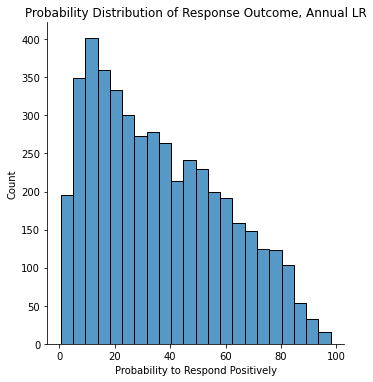

In [0]:
prob_ann = np.array(predictions_annual.select('probability').collect())[:, 0, 1]
plt.figure(figsize=(5,5))
sns.displot(data = prob_ann, x = 100*prob_ann)
plt.title('Probability Distribution of Response Outcome, Annual LR')
plt.xlabel('Probability to Respond Positively')
plt.ylabel('Count')
plt.show()

In [0]:
rdd = sc.parallelize(
    [
        (0., 1.), 
        (0., 0.), 
        (0., 0.), 
        (1., 1.), 
        (1.,0.), 
        (1.,0.),
        (1.,1.),
        (1.,1.)
    ]
)

# metricsp = MulticlassMetrics(predictions_annual.rdd)
# metricsp.recall(1)

tp = predictions_annual[(predictions_annual.response == 1) & (predictions_annual.prediction == 1)].count()
tn = predictions_annual[(predictions_annual.response == 0) & (predictions_annual.prediction == 0)].count()
fp = predictions_annual[(predictions_annual.response == 0) & (predictions_annual.prediction == 1)].count()
fn = predictions_annual[(predictions_annual.response == 1) & (predictions_annual.prediction == 0)].count()
print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)
print("Total", predictions_annual.count())

a = float((tp+tn)/(tp+tn+fp+fn))
print("accuracy", a)

r = float((tp)/(tp + fn))
print("recall", r)

p = float((tp) / (tp + fp))
print("precision", p)

True Positives: 288
True Negatives: 3095
False Positives: 1040
False Negatives: 166
Total 4589
accuracy 0.7371976465460884
recall 0.6343612334801763
precision 0.21686746987951808


In [0]:
cm = confusion_matrix(np.array(predictions_annual.select('response').collect()), np.array(predictions_annual.select('prediction').collect()))
print(cm)

[[3068 1067]
 [ 164  290]]


<Figure size 432x288 with 0 Axes>

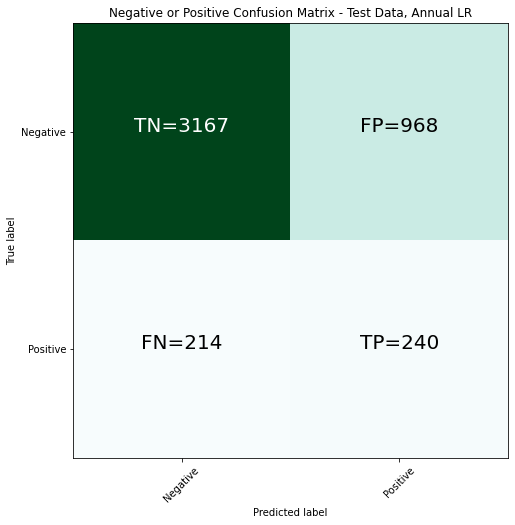

In [0]:
plt.clf()
plt.figure(figsize=(8,8))
plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.BuGn)
classNames = ['Negative', 'Positive']
plt.title('Negative or Positive Confusion Matrix - Test Data, Annual LR')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick = np.arange(len(classNames))
plt.xticks(tick, classNames, rotation = 45)
plt.yticks(tick, classNames)
s = [['TN', 'FP'], ['FN', 'TP']]
thresh = cm.max()/2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+ "=" + str(cm[i][j]), fontsize = 20,
                horizontalalignment = 'center',
                color = 'white' if cm[i,j]> thresh else 'black')

## Month LR

In [0]:
LR = LogisticRegression(featuresCol = 'Features', labelCol = 'response', weightCol = "weight", elasticNetParam= 1.0)
paramGrid = (ParamGridBuilder()
             .addGrid(LR.regParam, [0.001, 0.01, 0.02, 0.1, 1]) \
             .addGrid(LR.maxIter, [3, 5, 10]) \
             .build())

evaluator = BinaryClassificationEvaluator(labelCol='response', weightCol= 'weight')
tvs = TrainValidationSplit(estimator=LR,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    trainRatio=0.8)

model_LR_month = tvs.fit(month_train_s)
train_pred_m = model_LR_month.bestModel.transform(month_train_s)
predictions_month = model_LR_month.bestModel.transform(month_test_s)

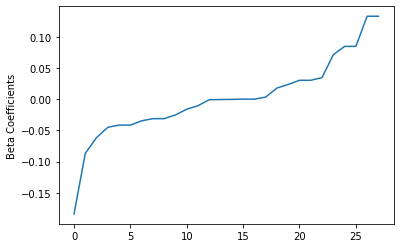

Best Param (regParam):  0.001
Best Param (MaxIter):  10


In [0]:
beta = np.sort(model_LR_month.bestModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()
print('Best Param (regParam): ', model_LR_month.bestModel._java_obj.getRegParam())
print('Best Param (MaxIter): ', model_LR.bestModel._java_obj.getMaxIter())

<Figure size 360x360 with 0 Axes>

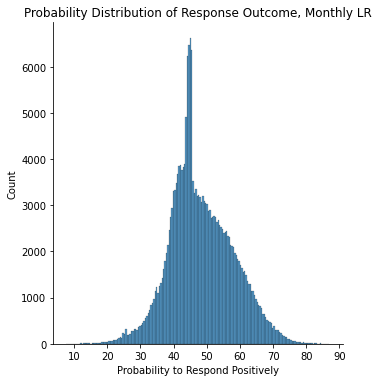

In [0]:
prob_mon = np.array(predictions_month.select('probability').collect())[:, 0, 1]
plt.figure(figsize=(5,5))
sns.displot(data = prob_mon, x = 100*prob_mon)
plt.title('Probability Distribution of Response Outcome, Monthly LR')
plt.xlabel('Probability to Respond Positively')
plt.ylabel('Count')
plt.show()

/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


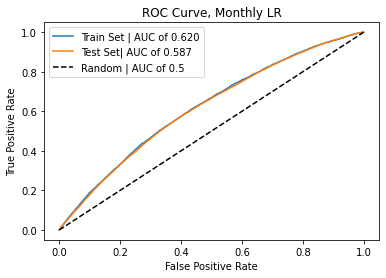

In [0]:
# Returns as a list (false positive rate, true positive rate)
preds = predictions_month.select('response','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['response'])))
points = CurveMetrics(preds).get_curve('roc')
trainingSummary = model_LR_month.bestModel.summary
roc = trainingSummary.roc.toPandas()
# test set
predictionAndLabels = predictions_month.select('response','prediction').rdd.map(lambda row: (float(row['prediction']), float(row['response'])))
metrics = BinaryClassificationMetrics(predictionAndLabels)
plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve, Monthly LR')
plt.plot(roc['FPR'], roc['TPR'], label = 'Train Set | AUC of {:4.3f}'.format((trainingSummary.areaUnderROC)))
plt.plot(x_val, y_val, label = 'Test Set| AUC of {:4.3f}'.format((metrics.areaUnderROC)))
plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random | AUC of 0.5')
plt.legend()
plt.show()

In [0]:
rdd = sc.parallelize(
    [
        (0., 1.), 
        (0., 0.), 
        (0., 0.), 
        (1., 1.), 
        (1.,0.), 
        (1.,0.),
        (1.,1.),
        (1.,1.)
    ]
)

# metricsp = MulticlassMetrics(predictions_annual.rdd)
# metricsp.recall(1)

tp = predictions_month[(predictions_month.response == 1) & (predictions_month.prediction == 1)].count()
tn = predictions_month[(predictions_month.response == 0) & (predictions_month.prediction == 0)].count()
fp = predictions_month[(predictions_month.response == 0) & (predictions_month.prediction == 1)].count()
fn = predictions_month[(predictions_month.response == 1) & (predictions_month.prediction == 0)].count()
print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)
print("Total", predictions_month.count())

a = float((tp+tn)/(tp+tn+fp+fn))
print("accuracy", a)

r = float((tp)/(tp + fn))
print("recall", r)

p = float((tp) / (tp + fp))
print("precision", p)

True Positives: 11132
True Negatives: 122196
False Positives: 73375
False Negatives: 9171
Total 215874
accuracy 0.6176195373226975
recall 0.5482933556617249
precision 0.13172873253103293


In [0]:
cm = confusion_matrix(np.array(predictions_month.select('response').collect()), np.array(predictions_month.select('prediction').collect()))
print(cm)

[[125307  70118]
 [  9626  10823]]


<Figure size 432x288 with 0 Axes>

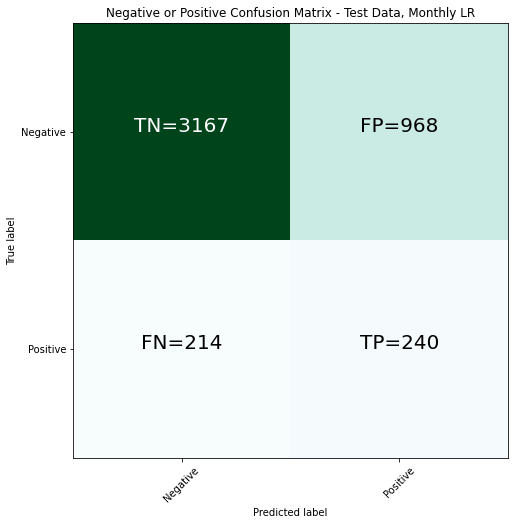

In [0]:
plt.clf()
plt.figure(figsize=(8,8))
plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.BuGn)
classNames = ['Negative', 'Positive']
plt.title('Negative or Positive Confusion Matrix - Test Data, Monthly LR')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick = np.arange(len(classNames))
plt.xticks(tick, classNames, rotation = 45)
plt.yticks(tick, classNames)
s = [['TN', 'FP'], ['FN', 'TP']]
thresh = cm.max()/2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+ "=" + str(cm[i][j]), fontsize = 20,
                horizontalalignment = 'center',
                color = 'white' if cm[i,j]> thresh else 'black')

## Annual Decision Tree

In [0]:
DT = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'response', weightCol = "weight")
paramGrid = (ParamGridBuilder()
             .addGrid(DT.maxDepth, [5, 10, 15, 20]) \
             .addGrid(DT.maxBins, [2, 4, 6]) \
             .build())

evaluator = BinaryClassificationEvaluator(labelCol='response', weightCol= 'weight')
tvs = TrainValidationSplit(estimator=DT,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    trainRatio=0.8)

model_DT = tvs.fit(annual_train)
train_pred_DT = model_DT.bestModel.transform(annual_train)
predictions_annual_DT = model_DT.bestModel.transform(annual_test)
auc_test_DT = evaluator.evaluate(predictions_annual_DT)

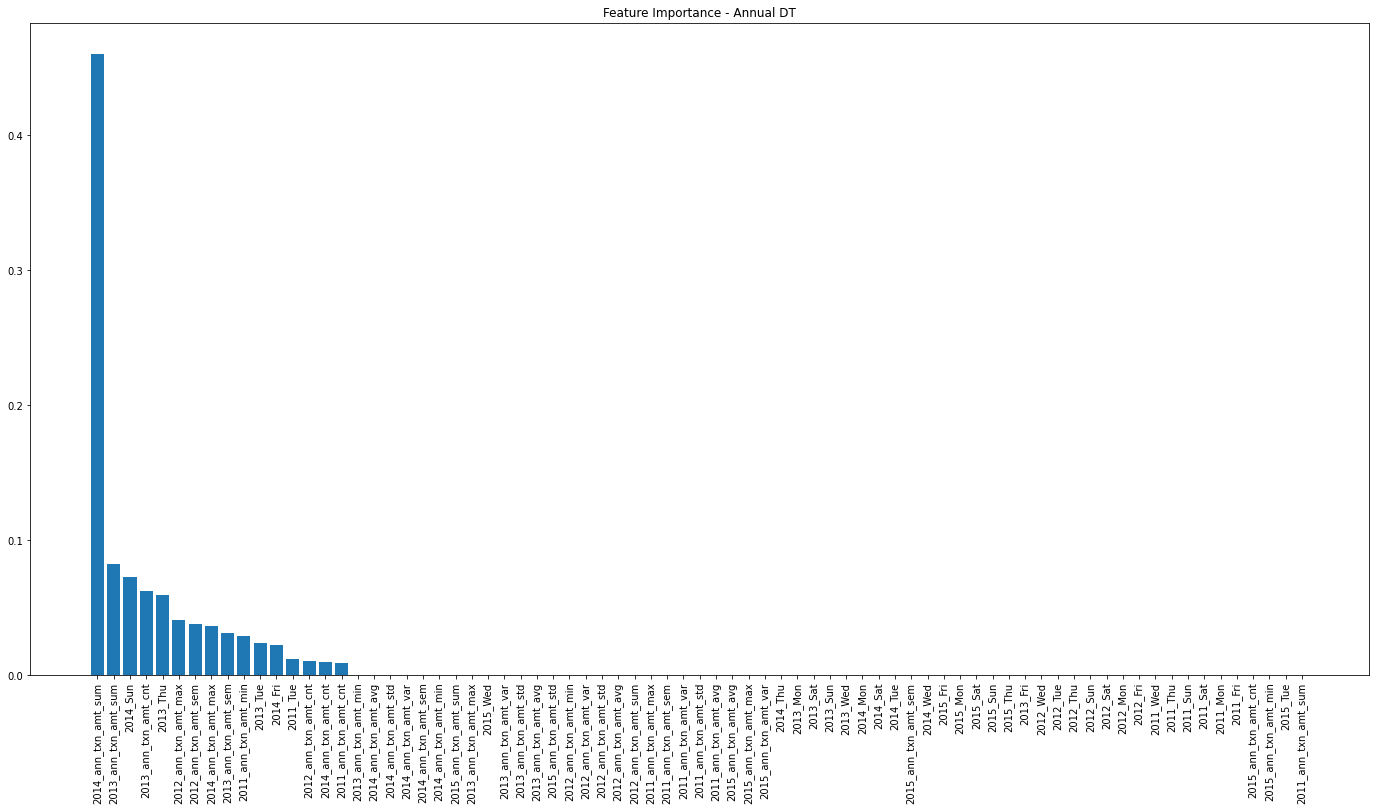

In [0]:
importances = model_DT.bestModel.featureImportances
indices = np.argsort(importances)[::-1]

names = [annual_features_outputs.columns[i] for i in indices]
# Create plot
plt.figure(figsize=(24,12))
# Create plot title
plt.title("Feature Importance - Annual DT")
# Add bars
x_axis = []
y_axis = []
for i in range(len(indices)):
    x_axis.append(i)
    idx = indices[i]
    y_axis.append(importances[int(idx)])
plt.bar(x_axis, y_axis)
# Add feature names as x-axis labels
plt.xticks(range(len(indices)), names, rotation=90)
# Show plot
plt.show()

In [0]:
print('Best Param (maxDepth): ', model_DT.bestModel._java_obj.getMaxDepth())
print('Best Param (maxBins): ', model_DT.bestModel._java_obj.getMaxBins())

Best Param (maxDepth):  5
Best Param (maxBins):  4


<Figure size 360x360 with 0 Axes>

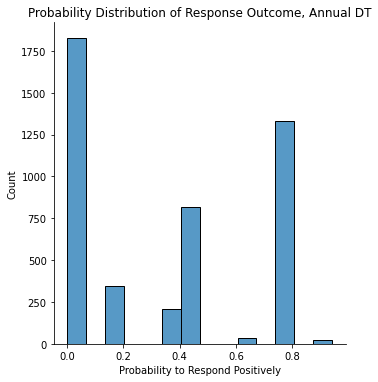

In [0]:
prob_ann_DT = np.array(predictions_annual_DT.select('probability').collect())[:, 0, 1]
plt.figure(figsize=(5,5))
sns.displot(data = prob_ann_DT)
plt.title('Probability Distribution of Response Outcome, Annual DT')
plt.xlabel('Probability to Respond Positively')
plt.ylabel('Count')
plt.show()

In [0]:
display(model_DT.bestModel, predictions_annual_DT.drop("prediction", "rawPrediction", "probability"))

treeNode
"{""index"":21,""featureType"":""continuous"",""prediction"":null,""threshold"":232.5,""categories"":null,""feature"":24,""overflow"":false}"
"{""index"":11,""featureType"":""continuous"",""prediction"":null,""threshold"":1.5,""categories"":null,""feature"":64,""overflow"":false}"
"{""index"":5,""featureType"":""continuous"",""prediction"":null,""threshold"":5.5,""categories"":null,""feature"":23,""overflow"":false}"
"{""index"":1,""featureType"":""continuous"",""prediction"":null,""threshold"":6.5,""categories"":null,""feature"":15,""overflow"":false}"
"{""index"":0,""featureType"":null,""prediction"":0.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":3,""featureType"":""continuous"",""prediction"":null,""threshold"":6.32285203440056,""categories"":null,""feature"":20,""overflow"":false}"
"{""index"":2,""featureType"":null,""prediction"":1.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":4,""featureType"":null,""prediction"":0.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":9,""featureType"":""continuous"",""prediction"":null,""threshold"":0.5,""categories"":null,""feature"":58,""overflow"":false}"
"{""index"":7,""featureType"":""continuous"",""prediction"":null,""threshold"":50.5,""categories"":null,""feature"":6,""overflow"":false}"


/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


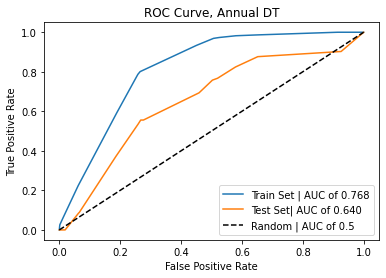

In [0]:
# Returns as a list (false positive rate, true positive rate)
preds = train_pred_DT.select('response','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['response'])))
points = CurveMetrics(preds).get_curve('roc')
preds_test = predictions_annual_DT.select('response','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['response'])))
points_test = CurveMetrics(preds_test).get_curve('roc')
# test set
predictionAndLabels = train_pred_DT.select('response','prediction').rdd.map(lambda row: (float(row['prediction']), float(row['response'])))
metrics = BinaryClassificationMetrics(predictionAndLabels)
predictionAndLabels_test = predictions_annual_DT.select('response','prediction').rdd.map(lambda row: (float(row['prediction']), float(row['response'])))
metrics_test = BinaryClassificationMetrics(predictionAndLabels_test)
plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
x_val_t = [x[0] for x in points_test]
y_val_t = [x[1] for x in points_test]
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve, Annual DT')
plt.plot(x_val, y_val, label = 'Train Set | AUC of {:4.3f}'.format((metrics.areaUnderROC)))
plt.plot(x_val_t, y_val_t, label = 'Test Set| AUC of {:4.3f}'.format((metrics_test.areaUnderROC)))
plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random | AUC of 0.5')
plt.legend()
plt.show()

In [0]:
rdd = sc.parallelize(
    [
        (0., 1.), 
        (0., 0.), 
        (0., 0.), 
        (1., 1.), 
        (1.,0.), 
        (1.,0.),
        (1.,1.),
        (1.,1.)
    ]
)

# metricsp = MulticlassMetrics(predictions_annual.rdd)
# metricsp.recall(1)

tp = predictions_annual_DT[(predictions_annual_DT.response == 1) & (predictions_annual_DT.prediction == 1)].count()
tn = predictions_annual_DT[(predictions_annual_DT.response == 0) & (predictions_annual_DT.prediction == 0)].count()
fp = predictions_annual_DT[(predictions_annual_DT.response == 0) & (predictions_annual_DT.prediction == 1)].count()
fn = predictions_annual_DT[(predictions_annual_DT.response == 1) & (predictions_annual_DT.prediction == 0)].count()
print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)
print("Total", predictions_annual_DT.count())

a = float((tp+tn)/(tp+tn+fp+fn))
print("accuracy", a)

r = float((tp)/(tp + fn))
print("recall", r)

p = float((tp) / (tp + fp))
print("precision", p)

True Positives: 234
True Negatives: 3016
False Positives: 1152
False Negatives: 187
Total 4589
accuracy 0.7082152974504249
recall 0.5558194774346793
precision 0.16883116883116883


In [0]:
cm = confusion_matrix(np.array(predictions_annual_DT.select('response').collect()), np.array(predictions_annual_DT.select('prediction').collect()))
print(cm)

[[3016 1152]
 [ 187  234]]


<Figure size 432x288 with 0 Axes>

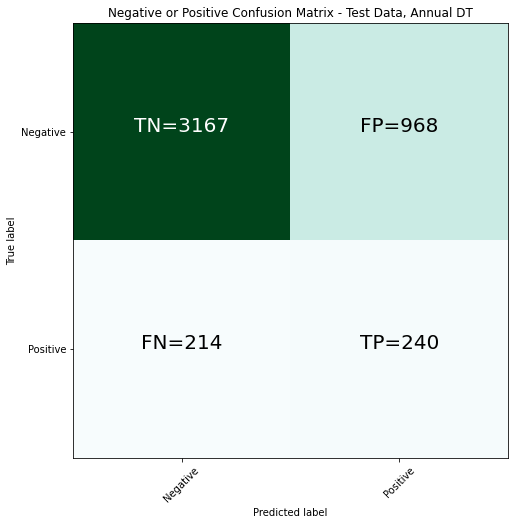

In [0]:
plt.clf()
plt.figure(figsize=(8,8))
plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.BuGn)
classNames = ['Negative', 'Positive']
plt.title('Negative or Positive Confusion Matrix - Test Data, Annual DT')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick = np.arange(len(classNames))
plt.xticks(tick, classNames, rotation = 45)
plt.yticks(tick, classNames)
s = [['TN', 'FP'], ['FN', 'TP']]
thresh = cm.max()/2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+ "=" + str(cm[i][j]), fontsize = 20,
                horizontalalignment = 'center',
                color = 'white' if cm[i,j]> thresh else 'black')

## Monthly Decision Tree

In [0]:
DT = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'response', weightCol = "weight")
paramGrid = (ParamGridBuilder()
             .addGrid(DT.maxDepth, [5, 10, 15, 20]) \
             .addGrid(DT.maxBins, [2, 4, 6]) \
             .build())

evaluator = BinaryClassificationEvaluator(labelCol='response', weightCol= 'weight')
tvs = TrainValidationSplit(estimator=DT,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    trainRatio=0.8)

model_month_DT = tvs.fit(month_train)
train_pred_month_DT = model_month_DT.bestModel.transform(month_train)
predictions_month_DT = model_month_DT.bestModel.transform(month_test)
auc_test_month_DT = evaluator.evaluate(predictions_month_DT)

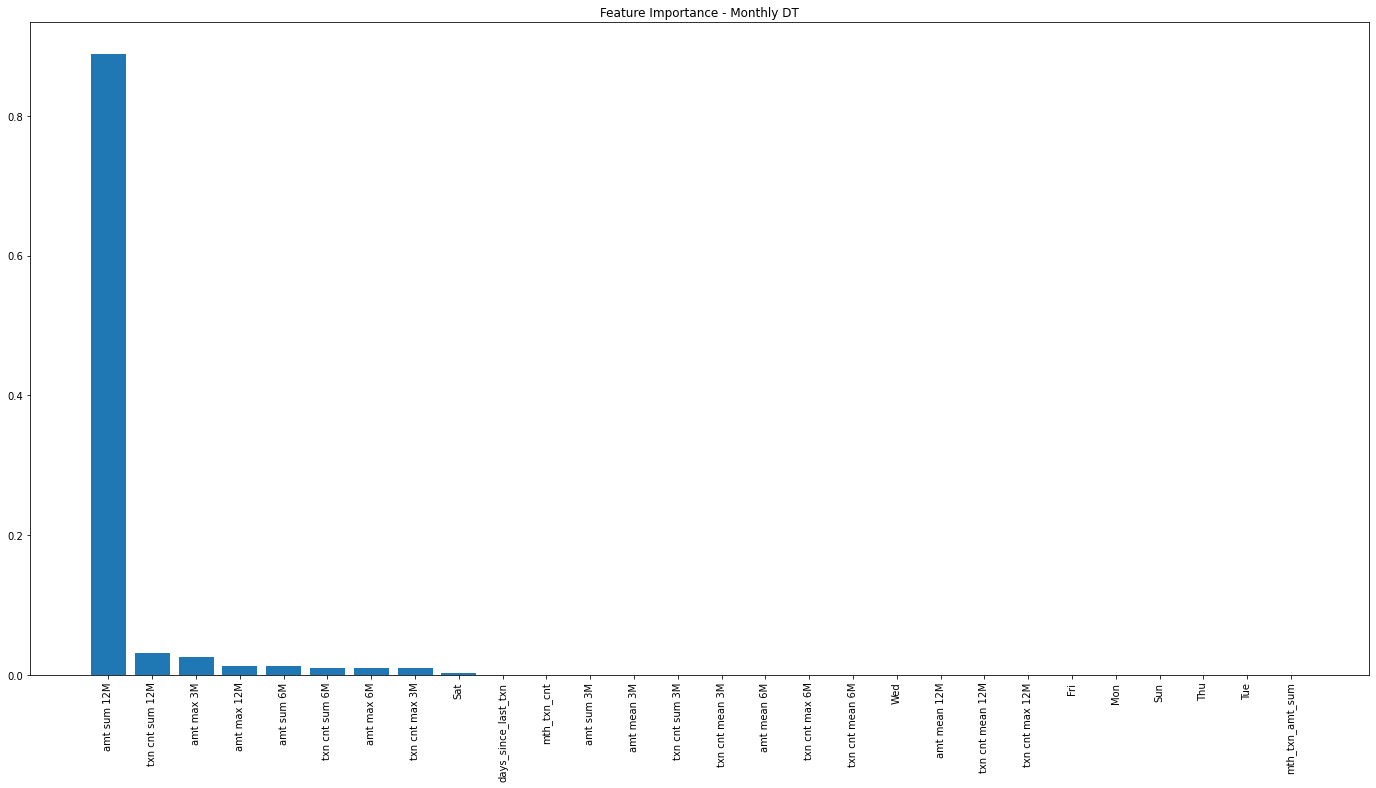

In [0]:
importances = model_month_DT.bestModel.featureImportances
indices = np.argsort(importances)[::-1]

names = [monthly_features_outputs.columns[i] for i in indices]
# Create plot
plt.figure(figsize=(24,12))
# Create plot title
plt.title("Feature Importance - Monthly DT")
# Add bars
x_axis = []
y_axis = []
for i in range(len(indices)):
    x_axis.append(i)
    idx = indices[i]
    y_axis.append(importances[int(idx)])
plt.bar(x_axis, y_axis)
# Add feature names as x-axis labels
plt.xticks(range(len(indices)), names, rotation=90)
# Show plot
plt.show()

In [0]:
print('Best Param (maxDepth): ', model_month_DT.bestModel._java_obj.getMaxDepth())
print('Best Param (maxBins): ', model_month_DT.bestModel._java_obj.getMaxBins())

Best Param (maxDepth):  5
Best Param (maxBins):  6


<Figure size 360x360 with 0 Axes>

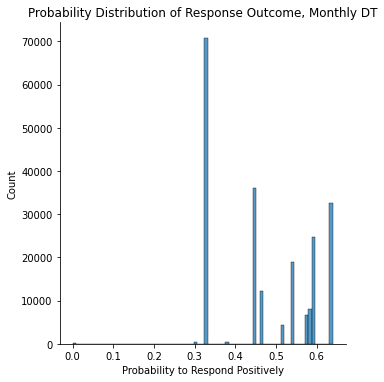

In [0]:
prob_mon_DT = np.array(predictions_month_DT.select('probability').collect())[:, 0, 1]
plt.figure(figsize=(5,5))
sns.displot(data = prob_mon_DT)
plt.title('Probability Distribution of Response Outcome, Monthly DT')
plt.xlabel('Probability to Respond Positively')
plt.ylabel('Count')
plt.show()

In [0]:
display(model_month_DT.bestModel, predictions_month_DT.drop("prediction", "rawPrediction", "probability"))

treeNode
"{""index"":13,""featureType"":""continuous"",""prediction"":null,""threshold"":257.5,""categories"":null,""feature"":14,""overflow"":false}"
"{""index"":11,""featureType"":""continuous"",""prediction"":null,""threshold"":5.0,""categories"":null,""feature"":14,""overflow"":false}"
"{""index"":5,""featureType"":""continuous"",""prediction"":null,""threshold"":81.5,""categories"":null,""feature"":4,""overflow"":false}"
"{""index"":1,""featureType"":""continuous"",""prediction"":null,""threshold"":136.5,""categories"":null,""feature"":8,""overflow"":false}"
"{""index"":0,""featureType"":null,""prediction"":0.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":3,""featureType"":""continuous"",""prediction"":null,""threshold"":1.5,""categories"":null,""feature"":7,""overflow"":false}"
"{""index"":2,""featureType"":null,""prediction"":1.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":4,""featureType"":null,""prediction"":0.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":7,""featureType"":""continuous"",""prediction"":null,""threshold"":2.5,""categories"":null,""feature"":11,""overflow"":false}"
"{""index"":6,""featureType"":null,""prediction"":1.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"


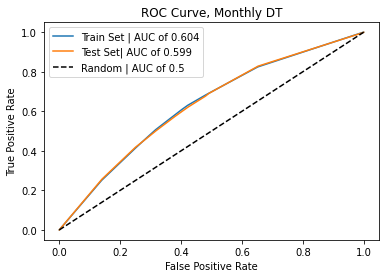

In [0]:
# Returns as a list (false positive rate, true positive rate)
preds = train_pred_month_DT.select('response','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['response'])))
points = CurveMetrics(preds).get_curve('roc')
preds_test = predictions_month_DT.select('response','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['response'])))
points_test = CurveMetrics(preds_test).get_curve('roc')
# test set
predictionAndLabels = train_pred_month_DT.select('response','prediction').rdd.map(lambda row: (float(row['prediction']), float(row['response'])))
metrics = BinaryClassificationMetrics(predictionAndLabels)
predictionAndLabels_test = predictions_month_DT.select('response','prediction').rdd.map(lambda row: (float(row['prediction']), float(row['response'])))
metrics_test = BinaryClassificationMetrics(predictionAndLabels_test)
plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
x_val_t = [x[0] for x in points_test]
y_val_t = [x[1] for x in points_test]
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve, Monthly DT')
plt.plot(x_val, y_val, label = 'Train Set | AUC of {:4.3f}'.format((metrics.areaUnderROC)))
plt.plot(x_val_t, y_val_t, label = 'Test Set| AUC of {:4.3f}'.format((metrics_test.areaUnderROC)))
plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random | AUC of 0.5')
plt.legend()
plt.show()

In [0]:
rdd = sc.parallelize(
    [
        (0., 1.), 
        (0., 0.), 
        (0., 0.), 
        (1., 1.), 
        (1.,0.), 
        (1.,0.),
        (1.,1.),
        (1.,1.)
    ]
)

# metricsp = MulticlassMetrics(predictions_annual.rdd)
# metricsp.recall(1)

tp = predictions_month_DT[(predictions_month_DT.response == 1) & (predictions_month_DT.prediction == 1)].count()
tn = predictions_month_DT[(predictions_month_DT.response == 0) & (predictions_month_DT.prediction == 0)].count()
fp = predictions_month_DT[(predictions_month_DT.response == 0) & (predictions_month_DT.prediction == 1)].count()
fn = predictions_month_DT[(predictions_month_DT.response == 1) & (predictions_month_DT.prediction == 0)].count()
print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)
print("Total", predictions_month_DT.count())

a = float((tp+tn)/(tp+tn+fp+fn))
print("accuracy", a)

r = float((tp)/(tp + fn))
print("recall", r)

p = float((tp) / (tp + fp))
print("precision", p)

True Positives: 12720
True Negatives: 112621
False Positives: 82804
False Negatives: 7729
Total 215874
accuracy 0.5806211030508538
recall 0.6220353073499927
precision 0.13316025292073197


In [0]:
cm = confusion_matrix(np.array(predictions_month_DT.select('response').collect()), np.array(predictions_month_DT.select('prediction').collect()))
print(cm)

[[112621  82804]
 [  7729  12720]]


<Figure size 432x288 with 0 Axes>

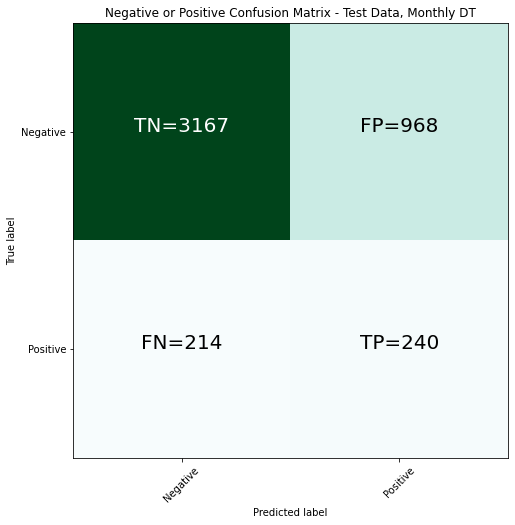

In [0]:
plt.clf()
plt.figure(figsize=(8,8))
plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.BuGn)
classNames = ['Negative', 'Positive']
plt.title('Negative or Positive Confusion Matrix - Test Data, Monthly DT')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick = np.arange(len(classNames))
plt.xticks(tick, classNames, rotation = 45)
plt.yticks(tick, classNames)
s = [['TN', 'FP'], ['FN', 'TP']]
thresh = cm.max()/2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+ "=" + str(cm[i][j]), fontsize = 20,
                horizontalalignment = 'center',
                color = 'white' if cm[i,j]> thresh else 'black')

## Annual Random Forest

In [0]:
RF = RandomForestClassifier(featuresCol = 'features', labelCol = 'response', weightCol = "weight")
paramGrid = (ParamGridBuilder()
             .addGrid(RF.maxDepth, [5, 10, 15, 20]) \
             .addGrid(RF.numTrees, [3, 5, 7, 10]) \
             .build())

evaluator = BinaryClassificationEvaluator(labelCol='response', weightCol= 'weight')
tvs = TrainValidationSplit(estimator=RF,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    trainRatio=0.8)

model_RF = tvs.fit(annual_train)
train_pred_RF = model_RF.bestModel.transform(annual_train)
predictions_RF = model_RF.bestModel.transform(annual_test)
auc_test_RF = evaluator.evaluate(predictions_RF)

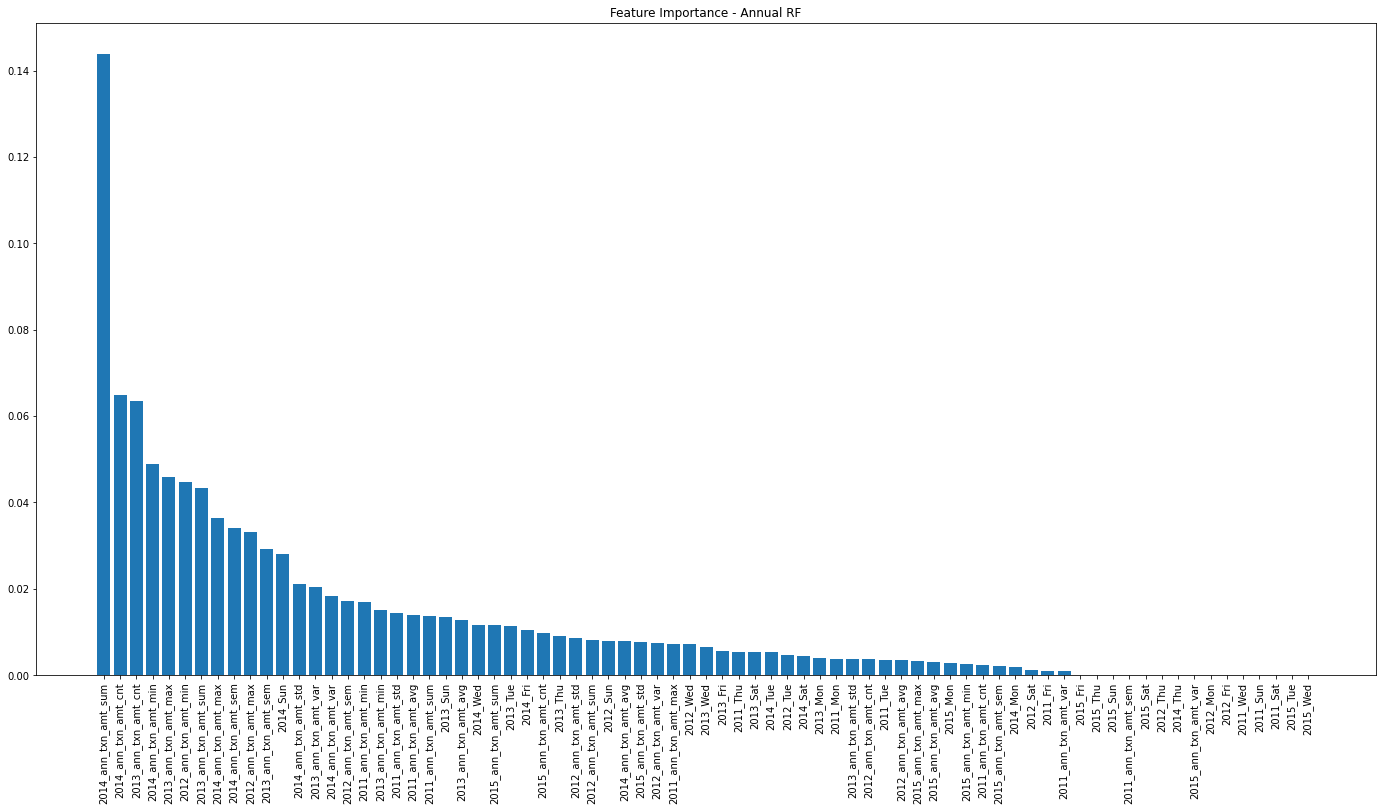

In [0]:
importances = model_RF.bestModel.featureImportances
indices = np.argsort(importances)[::-1]

names = [annual_features_outputs.columns[i] for i in indices]
# Create plot
plt.figure(figsize=(24,12))
# Create plot title
plt.title("Feature Importance - Annual RF")
# Add bars
x_axis = []
y_axis = []
for i in range(len(indices)):
    x_axis.append(i)
    idx = indices[i]
    y_axis.append(importances[int(idx)])
plt.bar(x_axis, y_axis)
# Add feature names as x-axis labels
plt.xticks(range(len(indices)), names, rotation=90)
# Show plot
plt.show()

In [0]:
print('Best Param (maxDepth): ', model_RF.bestModel._java_obj.getMaxDepth())
print('Best Param (numTrees): ', model_RF.bestModel._java_obj.getNumTrees())

Best Param (maxDepth):  5
Best Param (numTrees):  10


<Figure size 360x360 with 0 Axes>

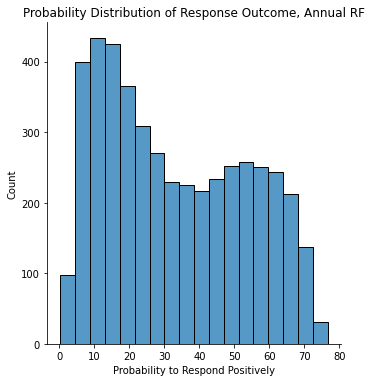

In [0]:
prob_ann_RF = np.array(predictions_RF.select('probability').collect())[:, 0, 1]
plt.figure(figsize=(5,5))
sns.displot(data = prob_ann_RF, x = 100*prob_ann_RF)
plt.title('Probability Distribution of Response Outcome, Annual RF')
plt.xlabel('Probability to Respond Positively')
plt.ylabel('Count')
plt.show()

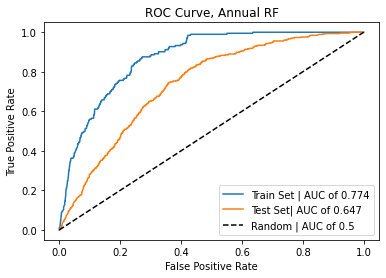

In [0]:
# Returns as a list (false positive rate, true positive rate)
preds = train_pred_RF.select('response','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['response'])))
points = CurveMetrics(preds).get_curve('roc')
preds_test = predictions_RF.select('response','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['response'])))
points_test = CurveMetrics(preds_test).get_curve('roc')
# test set
predictionAndLabels = train_pred_RF.select('response','prediction').rdd.map(lambda row: (float(row['prediction']), float(row['response'])))
metrics = BinaryClassificationMetrics(predictionAndLabels)
predictionAndLabels_test = predictions_RF.select('response','prediction').rdd.map(lambda row: (float(row['prediction']), float(row['response'])))
metrics_test = BinaryClassificationMetrics(predictionAndLabels_test)
plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
x_val_t = [x[0] for x in points_test]
y_val_t = [x[1] for x in points_test]
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve, Annual RF')
plt.plot(x_val, y_val, label = 'Train Set | AUC of {:4.3f}'.format((metrics.areaUnderROC)))
plt.plot(x_val_t, y_val_t, label = 'Test Set| AUC of {:4.3f}'.format((metrics_test.areaUnderROC)))
plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random | AUC of 0.5')
plt.legend()
plt.show()

In [0]:
rdd = sc.parallelize(
    [
        (0., 1.), 
        (0., 0.), 
        (0., 0.), 
        (1., 1.), 
        (1.,0.), 
        (1.,0.),
        (1.,1.),
        (1.,1.)
    ]
)

# metricsp = MulticlassMetrics(predictions_annual.rdd)
# metricsp.recall(1)

tp = predictions_RF[(predictions_RF.response == 1) & (predictions_RF.prediction == 1)].count()
tn = predictions_RF[(predictions_RF.response == 0) & (predictions_RF.prediction == 0)].count()
fp = predictions_RF[(predictions_RF.response == 0) & (predictions_RF.prediction == 1)].count()
fn = predictions_RF[(predictions_RF.response == 1) & (predictions_RF.prediction == 0)].count()
print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)
print("Total", predictions_RF.count())

a = float((tp+tn)/(tp+tn+fp+fn))
print("accuracy", a)

r = float((tp)/(tp + fn))
print("recall", r)

p = float((tp) / (tp + fp))
print("precision", p)

True Positives: 240
True Negatives: 3167
False Positives: 968
False Negatives: 214
Total 4589
accuracy 0.7424275441272609
recall 0.5286343612334802
precision 0.1986754966887417


In [0]:
cm = confusion_matrix(np.array(predictions_RF.select('response').collect()), np.array(predictions_RF.select('prediction').collect()))
print(cm)

[[3167  968]
 [ 214  240]]


<Figure size 432x288 with 0 Axes>

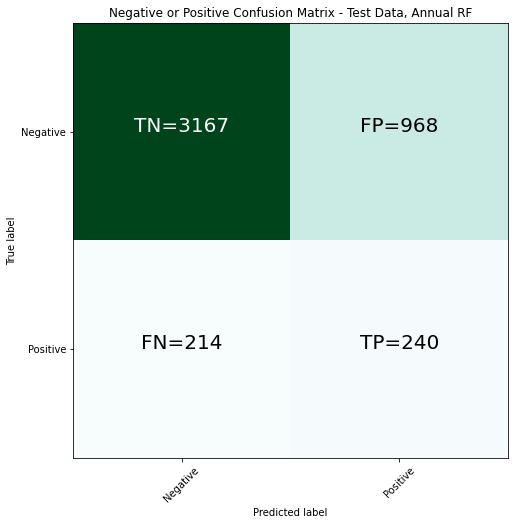

In [0]:
plt.clf()
plt.figure(figsize=(8,8))
plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.BuGn)
classNames = ['Negative', 'Positive']
plt.title('Negative or Positive Confusion Matrix - Test Data, Annual RF')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick = np.arange(len(classNames))
plt.xticks(tick, classNames, rotation = 45)
plt.yticks(tick, classNames)
s = [['TN', 'FP'], ['FN', 'TP']]
thresh = cm.max()/2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+ "=" + str(cm[i][j]), fontsize = 20,
                horizontalalignment = 'center',
                color = 'white' if cm[i,j]> thresh else 'black')

## Monthly Random Forest

In [0]:
RF = RandomForestClassifier(featuresCol = 'features', labelCol = 'response', weightCol = "weight")
paramGrid = (ParamGridBuilder()
             .addGrid(RF.maxDepth, [5, 10, 15, 20]) \
             .addGrid(RF.numTrees, [3, 5, 7, 10]) \
             .build())

evaluator = BinaryClassificationEvaluator(labelCol='response', weightCol= 'weight')
tvs = TrainValidationSplit(estimator=RF,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    trainRatio=0.8)

model_month_RF = tvs.fit(month_train)
train_pred_month_RF = model_month_RF.bestModel.transform(month_train)
predictions_month_RF = model_month_RF.bestModel.transform(month_test)
auc_test_month_RF = evaluator.evaluate(predictions_month_RF)

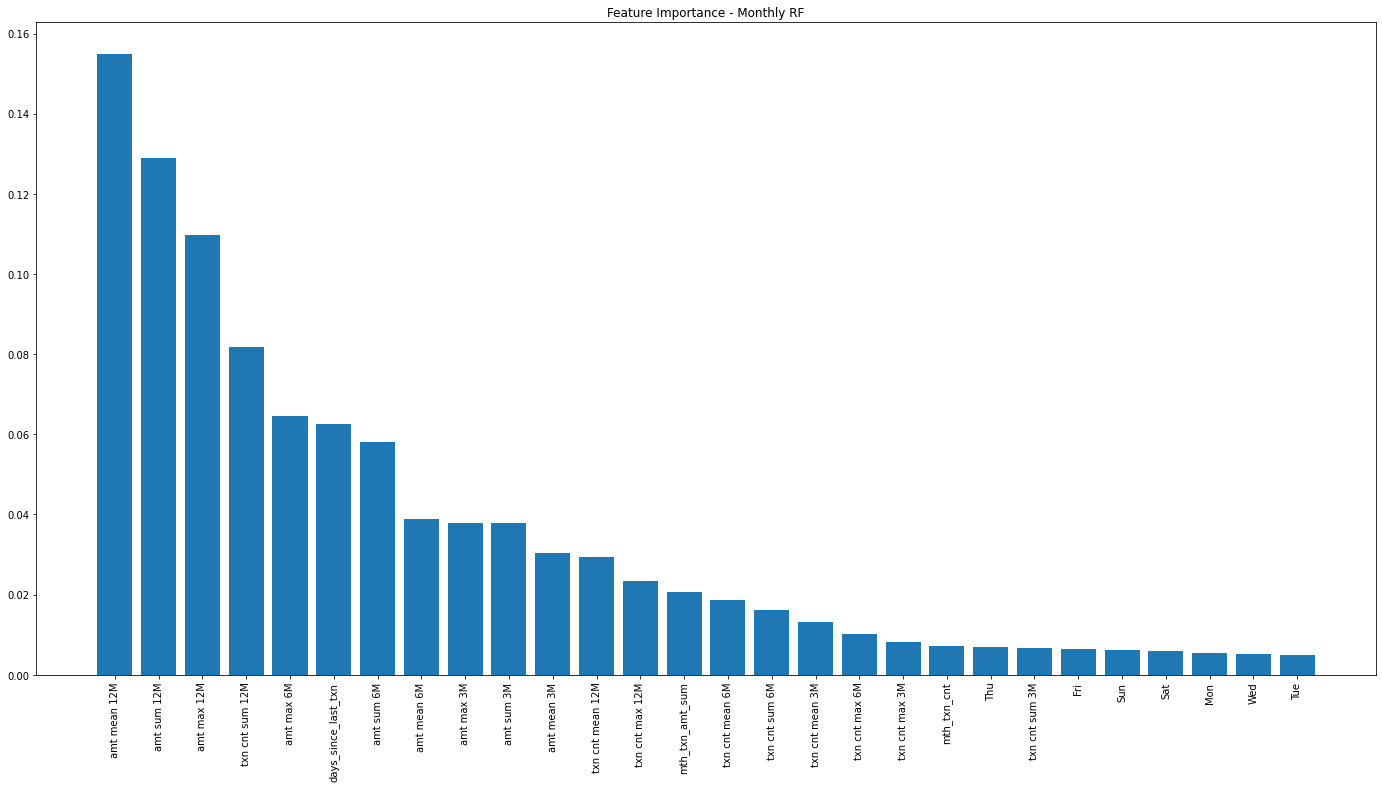

In [0]:
importances = model_month_RF.bestModel.featureImportances
indices = np.argsort(importances)[::-1]

names = [monthly_features_outputs.columns[i] for i in indices]
# Create plot
plt.figure(figsize=(24,12))
# Create plot title
plt.title("Feature Importance - Monthly RF")
# Add bars
x_axis = []
y_axis = []
for i in range(len(indices)):
    x_axis.append(i)
    idx = indices[i]
    y_axis.append(importances[int(idx)])
plt.bar(x_axis, y_axis)
# Add feature names as x-axis labels
plt.xticks(range(len(indices)), names, rotation=90)
# Show plot
plt.show()

In [0]:
print('Best Param (maxDepth): ', model_month_RF.bestModel._java_obj.getMaxDepth())
print('Best Param (numTrees): ', model_month_RF.bestModel._java_obj.getNumTrees())

Best Param (maxDepth):  10
Best Param (numTrees):  10


<Figure size 360x360 with 0 Axes>

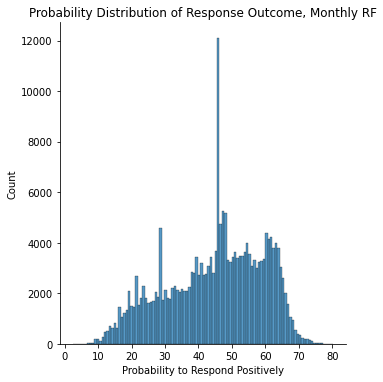

In [0]:
prob_mon_RF = np.array(predictions_month_RF.select('probability').collect())[:, 0, 1]
plt.figure(figsize=(5,5))
sns.displot(data = prob_mon_RF, x = 100*prob_mon_RF)
plt.title('Probability Distribution of Response Outcome, Monthly RF')
plt.xlabel('Probability to Respond Positively')
plt.ylabel('Count')
plt.show()

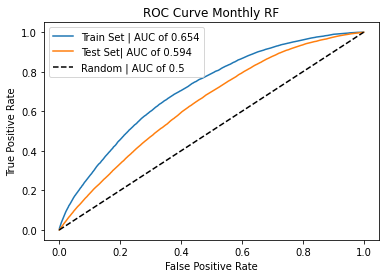

In [0]:
# Returns as a list (false positive rate, true positive rate)
preds = train_pred_month_RF.select('response','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['response'])))
points = CurveMetrics(preds).get_curve('roc')
preds_test = predictions_month_RF.select('response','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['response'])))
points_test = CurveMetrics(preds_test).get_curve('roc')
# test set
predictionAndLabels = train_pred_month_RF.select('response','prediction').rdd.map(lambda row: (float(row['prediction']), float(row['response'])))
metrics = BinaryClassificationMetrics(predictionAndLabels)
predictionAndLabels_test = predictions_month_RF.select('response','prediction').rdd.map(lambda row: (float(row['prediction']), float(row['response'])))
metrics_test = BinaryClassificationMetrics(predictionAndLabels_test)
plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
x_val_t = [x[0] for x in points_test]
y_val_t = [x[1] for x in points_test]
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve Monthly RF')
plt.plot(x_val, y_val, label = 'Train Set | AUC of {:4.3f}'.format((metrics.areaUnderROC)))
plt.plot(x_val_t, y_val_t, label = 'Test Set| AUC of {:4.3f}'.format((metrics_test.areaUnderROC)))
plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random | AUC of 0.5')
plt.legend()
plt.show()

In [0]:
rdd = sc.parallelize(
    [
        (0., 1.), 
        (0., 0.), 
        (0., 0.), 
        (1., 1.), 
        (1.,0.), 
        (1.,0.),
        (1.,1.),
        (1.,1.)
    ]
)

# metricsp = MulticlassMetrics(predictions_annual.rdd)
# metricsp.recall(1)

tp = predictions_month_RF[(predictions_month_RF.response == 1) & (predictions_month_RF.prediction == 1)].count()
tn = predictions_month_RF[(predictions_month_RF.response == 0) & (predictions_month_RF.prediction == 0)].count()
fp = predictions_month_RF[(predictions_month_RF.response == 0) & (predictions_month_RF.prediction == 1)].count()
fn = predictions_month_RF[(predictions_month_RF.response == 1) & (predictions_month_RF.prediction == 0)].count()
print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)
print("Total", predictions_RF.count())

a = float((tp+tn)/(tp+tn+fp+fn))
print("accuracy", a)

r = float((tp)/(tp + fn))
print("recall", r)

p = float((tp) / (tp + fp))
print("precision", p)

True Positives: 11452
True Negatives: 121920
False Positives: 73651
False Negatives: 8851
Total 4589
accuracy 0.617823359922918
recall 0.5640545732157809
precision 0.13456634901237324


In [0]:
cm = confusion_matrix(np.array(predictions_month_RF.select('response').collect()), np.array(predictions_month_RF.select('prediction').collect()))
print(cm)

[[121920  73651]
 [  8851  11452]]


<Figure size 432x288 with 0 Axes>

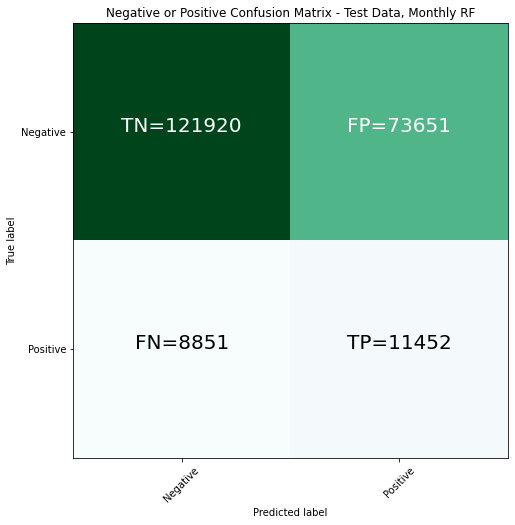

In [0]:
plt.clf()
plt.figure(figsize=(8,8))
plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.BuGn)
classNames = ['Negative', 'Positive']
plt.title('Negative or Positive Confusion Matrix - Test Data, Monthly RF')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick = np.arange(len(classNames))
plt.xticks(tick, classNames, rotation = 45)
plt.yticks(tick, classNames)
s = [['TN', 'FP'], ['FN', 'TP']]
thresh = cm.max()/2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+ "=" + str(cm[i][j]), fontsize = 20,
                horizontalalignment = 'center',
                color = 'white' if cm[i,j]> thresh else 'black')

## Comparison of Methods

| Model | Timeline | Hyperparameters | Top 2 Features | Accuracy | Precision | Recall | Test AUC |
| ----- | -------- | --------------- | -------------- | -------- | --------- | ------ | --- |
| L1 Logistic Regression | Annual | C = 0.01, penalty = 'l1', maxIter = 10 | Coefficients plotted | 0.737 | 0.217 | 0.634 | 0.691 |
|  | Monthly | C = 0.001, penalty = 'l1', maxIter = 10 | Coefficients plotted | 0.618 | 0.132 | 0.548 | 0.587 |
| Decision Tree | Annual | maxDepth = 5, maxBins = 4 | '2014_ann_txn_amt_sum', '2013_ann_txn_amt_sum' | 0.708 | 0.169 | 0.556 | 0.640 |
|  | Monthly | maxDepth = 5, maxBins = 6 | 'amt sum 12M', 'txn cnt sum 12M' | 0.581 | 0.133 | 0.622 | 0.599 |
| Random Forest | Annual | maxDepth = 5, numTrees = 10 | '2014_ann_txn_amt_sum', '2014_ann_txn_amt_cnt' | 0.742 | 0.199 | 0.529 | 0.647 | 
|  | Monthly | maxDepth = 10, numTrees = 10 | 'amt sum 12M' and 'amt mean 12M' | 0.618 | 0.135 | 0.564 | 0.594 |

With the results obtained (above), a decision can be made on the best combination of feature engineering (annual vs monthly) and the three modelling approaches to be used in a production environment.  
  
**Note:** All models have balanced class weights as the data is very negatively weighted (seen at the beginning of the file) at 10:1 negative:positive ratio. Additionally, all results above are the results of the trained model on test data.

**Data was balanced using a weighted method by using a ratio between positive and negative responses**

By observing the top 2 features of each modelling approach and their respective feature engineering datasets, the pairs of top features are all very similar amongst all 3 models. This is a good depiction that the models are comparing and classifying the data similarly, thus allowing a more contextual analysis of the performance markers. However, any instances of 'max' in the features should be viewed with caution as that is not a good indicator of the dataset. Additionally, it was more difficult to compare the logistic regression (LR) models as there is no feature importance support in pyspark for LR.
  
Starting off with the annual data, it is observed that the random forest (RF) model offers the highest accuracy of the 3 models. this means that the decision tree model was able to make more correct guesses on the test model overall however, this does not represent how many false guesses the model made. The LR model has the highest precison, reflecting a lower error in predicting false positives (FP). Additionally, the decision tree (DT) model had comparable results, but has the lowest accuracy and precision of the 3 models. Lastly, the L1 logistic regression model yielded the highest AUC score (by apx. 0.5). This means the logistic regression model has a good ability to differentiate between the positive and negative class.
  
For the monthly data, the RF model yielded the highest precision score, DT with the highest recall and test AUC, and LR and RF tied in model accuracy. 

By looking at the probability distributions, it is seen that only the decision tree model generated discrete buckets (discontinuous data) given that the max number of bins did not span a large enough distribution. None of the models generated a gaussian distribution, with logistic regression being the only model with "one" peak in the curve. The RF distribution had peaks at specific probabilities and much smaller data representation to fill in spots between peaks. This looked similar to the combination of a logistic regression and decision tree plot model. 

Discussing on the ROC curves of each model, it is seen that the annual data tend to lean on overfitting with a 12-13% difference in AUC in the **RF model**. However, the LR on has an AUC difference of ~10%. It can be seen that the monthly curves for LR is much closer.

However, the annual data metrics outperform most of the monthly data metrics, and the measures where the monthly data outperform the annual data significantly will be further analyzed. 
  - RF and DT recall has a low annual recall score compared with the monthly score, which is a factor to consider when selecting the desired model
    - makes more FN guesses than other models


From these obeservations and given data, it can be said that:
  - LR distinguishes the binary classification problem best
  - The annual data provides better performance metrics than the monthly data

With all of the investigation in mind, it is time to choose the optimal model for this problem. 

The feature engineering model to be selected will be: **annual_features_outputs**
  - chosen because of better performance metrics for most categories in all models
  - much higher precision and recall performance than the monthly data

The modelling approach to be selected will be: **L1 Logistic Regression**
 - highest AUC
 - very comparative precision and recall  
 

**L1 logistic regression** is the chosen model because of its high AUC score. This means the model is able to properly classify the data better than the other 2 models. Accuracy is a parameter that holds little significance in this analysis as the data has been balanced. To apply the model to the raw dataset, the L1 logistic regression model will yield more accurate predictions. It has a comparable precision and recall score to the highest scores in this test, combined with the high AUC score suggests that the model will be making the most balanced and better (on average) predictions.

Therefore, the **L1 Logistic Regression** model and the **annual_features_outputs** will be chosen from this analysis to be deployed in the production environment.